# ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


# ⏳ Load the Data

In [3]:
data = np.load("/kaggle/input/an2dl-homework-2/mars_for_students.npz")

training_set = data["training_set"]
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]

X_test = data["test_set"]

num_classes = 5

print(f"Training X shape: {X_train_val.shape}")
print(f"Training y shape: {y_train_val.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


# Data visualization and preprocessing

## Class distribution

In [4]:
def count_class_occurrences(masks, num_classes=num_classes):
    class_counts = {i: 0 for i in range(num_classes)}  # Initialize count for each class
    unique, counts = np.unique(masks, return_counts=True)  # Unique classes and counts
    for class_id, count in zip(unique, counts):
        class_counts[class_id] = count  # Map counts to class IDs
    return class_counts

In [5]:
def plot_class_distribution(class_counts, class_names, title="Class Distribution"):
    classes = [class_names[c] for c in class_counts.keys()]
    counts = list(class_counts.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color='skyblue', alpha=0.8)
    plt.xlabel("Class Name", fontsize=14)
    plt.ylabel("Pixel Count", fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [6]:
class_names = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}

Class Occurrences in Training Set:
Class 0 - Background: 5466886 pixels
Class 1 - Soil: 7131118 pixels
Class 2 - Bedrock: 4863930 pixels
Class 3 - Sand: 3933183 pixels
Class 4 - Big Rock: 26963 pixels


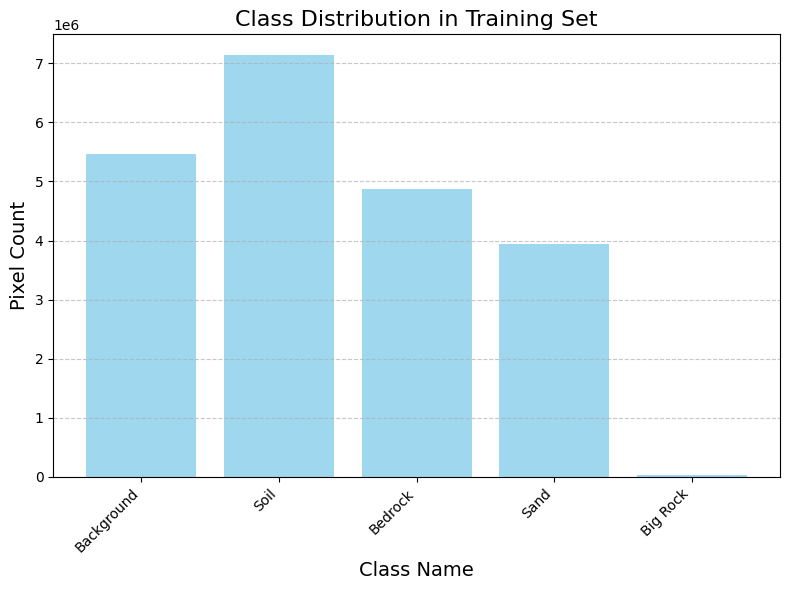

In [7]:
# Reshape y_train to extract the masks for processing
masks = np.array([y.squeeze() for y in y_train_val])

# Count occurrences of each class in training labels
class_counts = count_class_occurrences(masks, num_classes=num_classes)

print("Class Occurrences in Training Set:")
for class_id, count in class_counts.items():
    print(f"Class {class_id} - {class_names[class_id]}: {count} pixels")

plot_class_distribution(class_counts, class_names, title="Class Distribution in Training Set")

## Image visualization

In [8]:
import matplotlib.pyplot as plt

def visualize_images_with_mask(images, masks=None, num_images=8, images_per_row=2, title="Images"):
    rows = (num_images + images_per_row - 1) // images_per_row  # Calculate number of rows needed
    plt.figure(figsize=(20, 5 * rows))
    
    for i in range(num_images):
        # Plot the original image
        plt.subplot(rows, images_per_row * 2, i * 2 + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")  # Assuming grayscale images
        plt.axis("off")
        plt.title(f"Image {i + 1}")
        
        # Plot the mask (if available)
        if masks is not None:
            plt.subplot(rows, images_per_row * 2, i * 2 + 2)
            plt.imshow(masks[i].squeeze(), cmap="viridis")  # Use a color map for segmentation
            plt.axis("off")
            plt.title(f"Mask {i + 1}")
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [9]:
import matplotlib.pyplot as plt

def visualize_images_without_mask(images, num_images=8, images_per_row=4, title="Images"):
    rows = (num_images + images_per_row - 1) // images_per_row  # Calculate number of rows needed
    plt.figure(figsize=(20, 5 * rows))
    
    for i in range(num_images):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")  # Assuming grayscale images
        plt.axis("off")
        plt.title(f"Image {i + 1}")
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


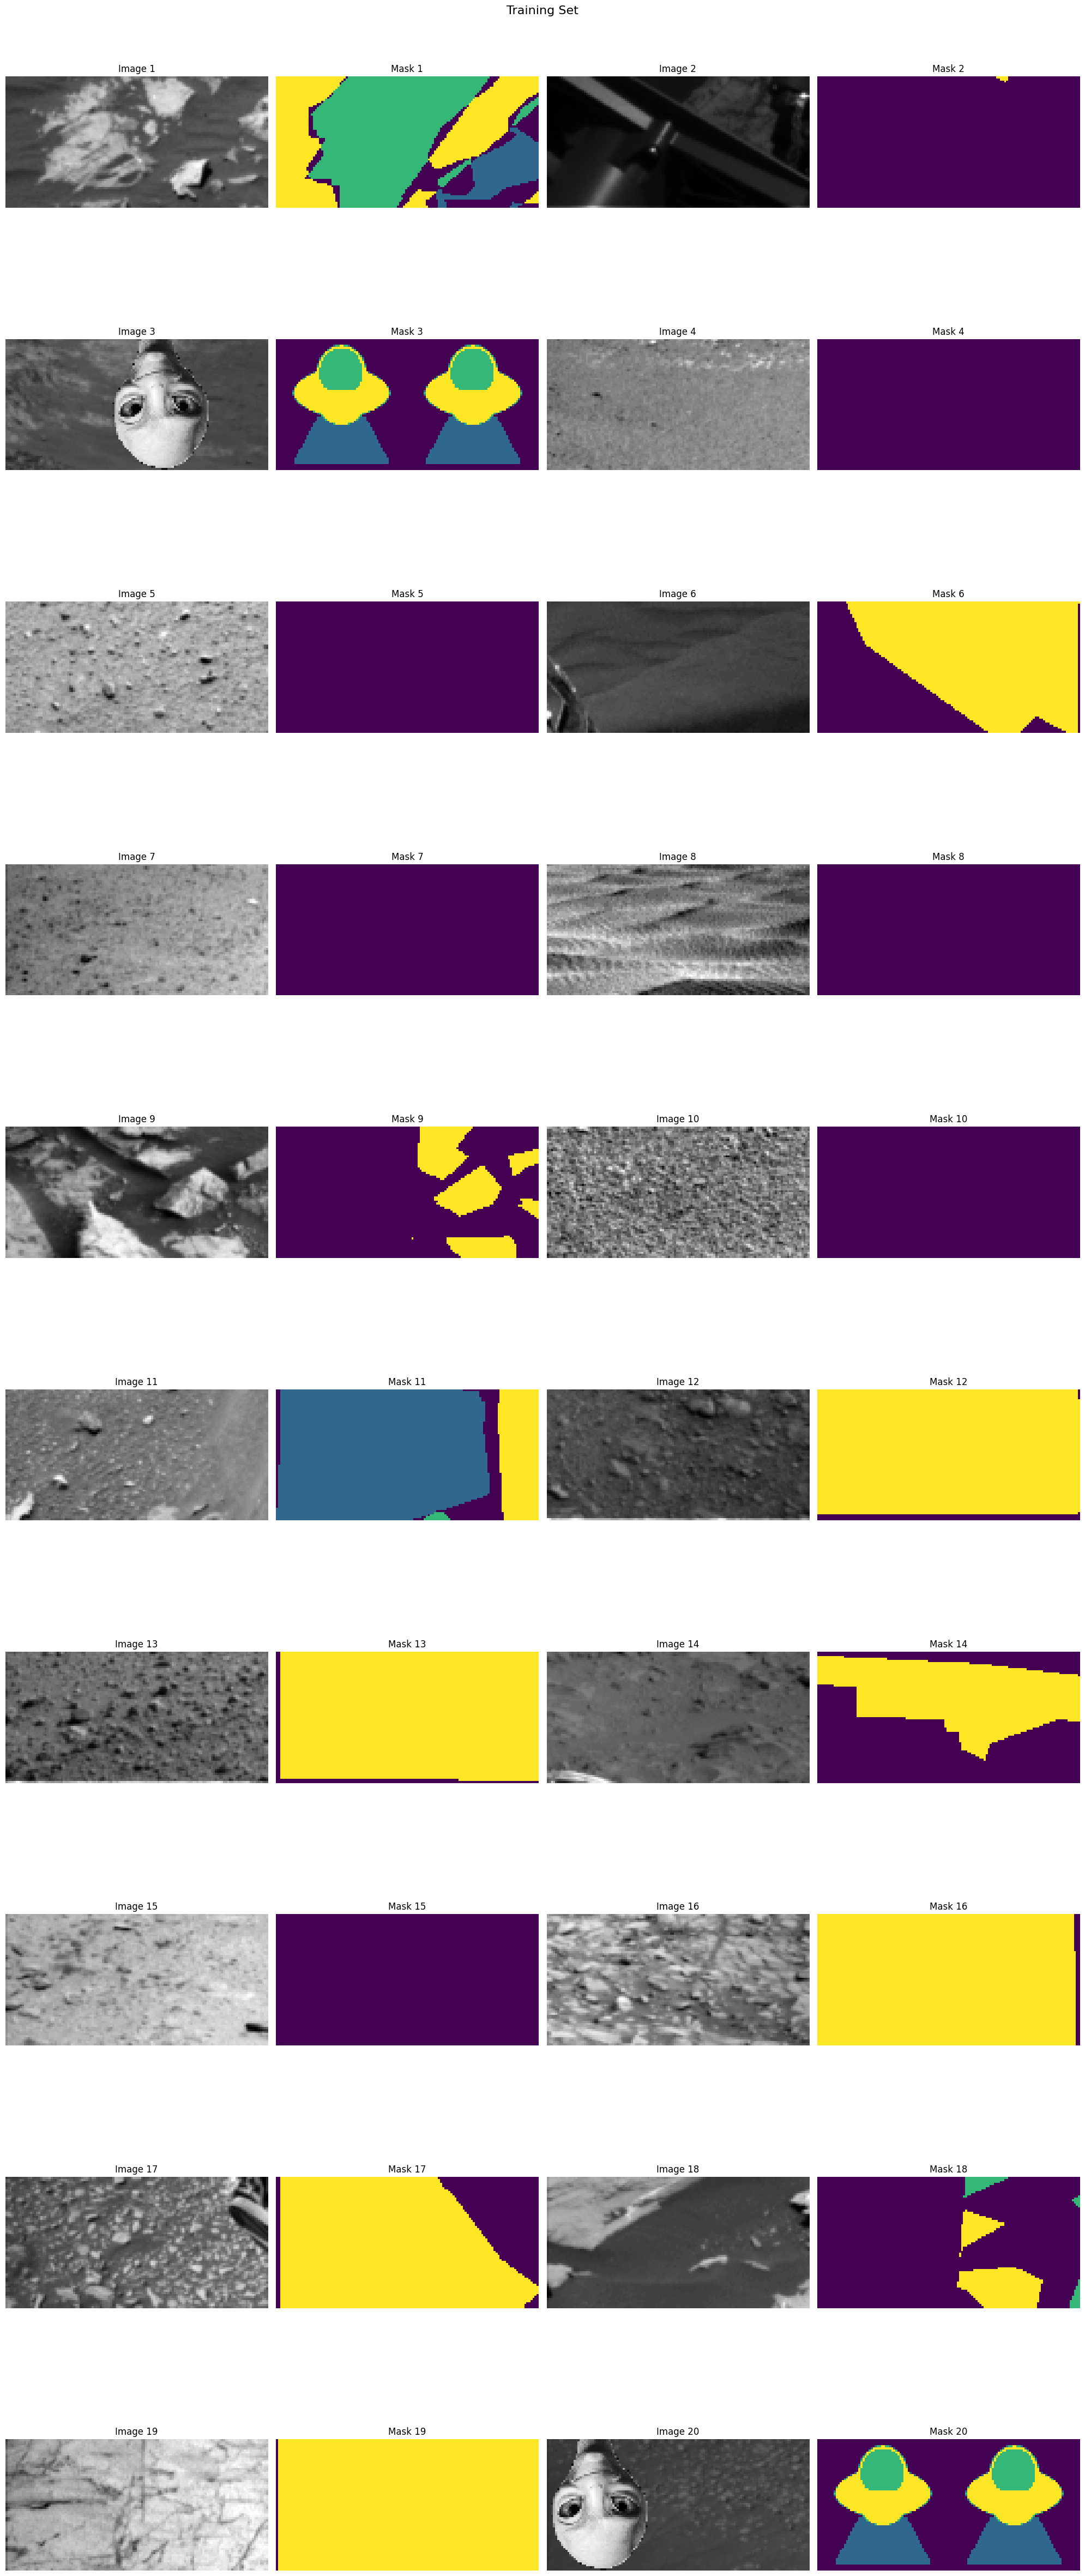

In [10]:
visualize_images_with_mask(X_train_val[60:80], masks=y_train_val[60:80], num_images=20, title="Training Set")

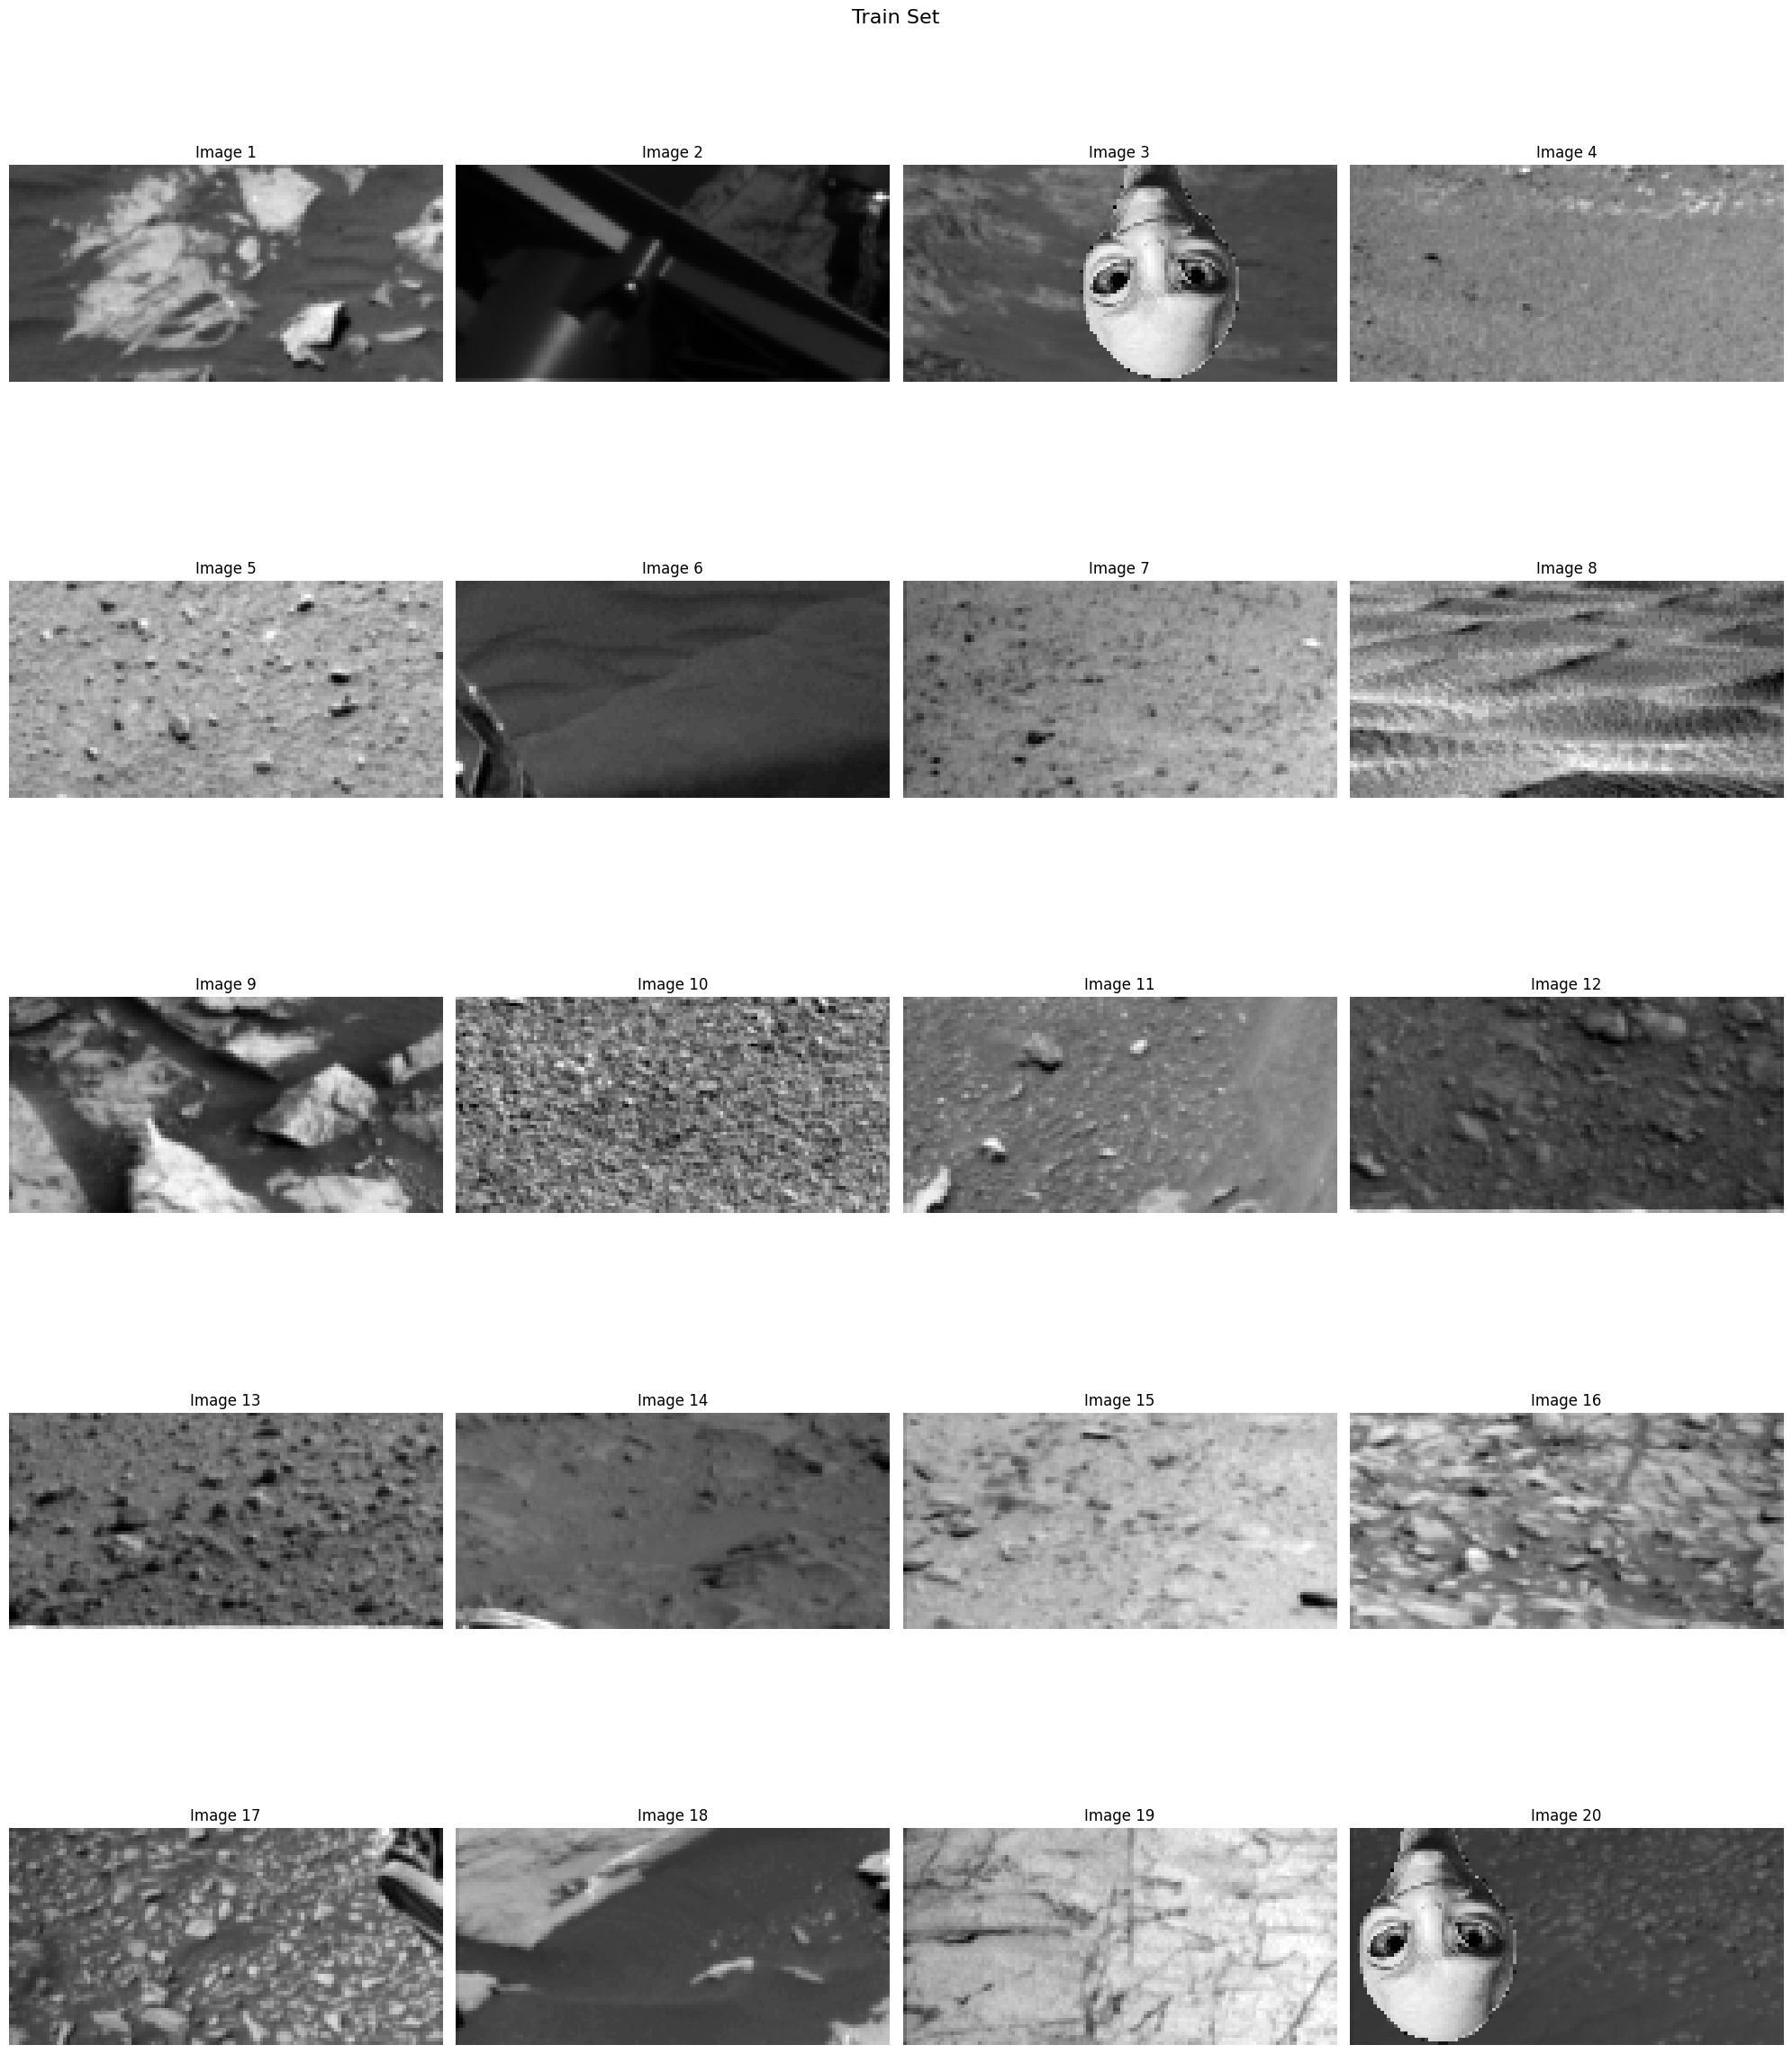

In [11]:
visualize_images_without_mask(X_train_val[60:80], num_images=20, title="Train Set")

We can see a couple of examples of modified images in the training set at index 62 and and 79

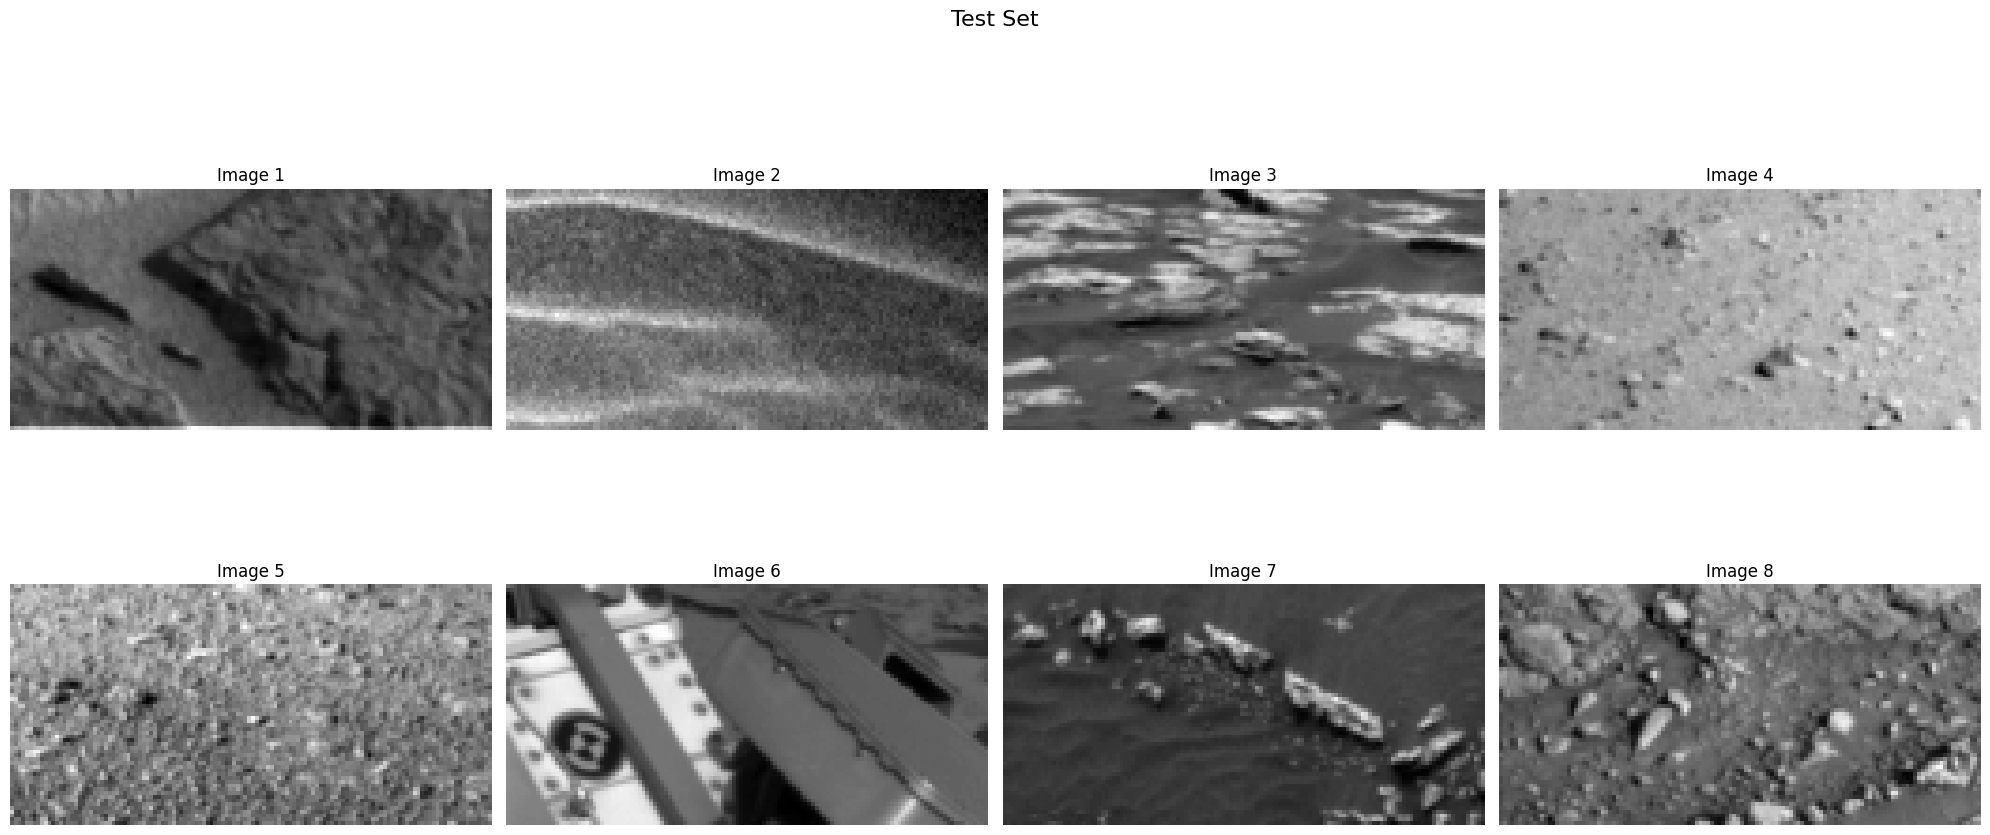

In [12]:
visualize_images_without_mask(X_test, title="Test Set")

## Alien removal

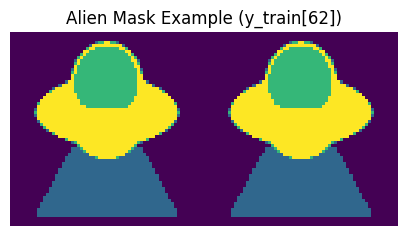

In [13]:
import matplotlib.pyplot as plt

# Visualize the alien mask at y_train[62]
alien_mask_example = y_train_val[62]

# Plot the mask
plt.figure(figsize=(5, 5))
plt.imshow(alien_mask_example, cmap="viridis")
plt.title("Alien Mask Example (y_train[62])")
plt.axis("off")
plt.show()

In [14]:
def visualize_alien_images(images, masks, alien_indices, num_images=10, num_images_per_row=5):
    # Calculate the number of rows needed for images
    num_rows = (num_images + num_images_per_row - 1) // num_images_per_row  # This rounds up
    
    # Create a larger figure size based on the number of rows and columns
    plt.figure(figsize=(15, 3 * num_rows))
    
    for i in range(min(num_images, len(alien_indices))):
        idx = alien_indices[i]
        
        # Determine the row and column for the image and mask
        row = i // num_images_per_row
        col = i % num_images_per_row
        
        # Display the image in the first row for each group
        plt.subplot(2 * num_rows, num_images_per_row, i + 1 + row * num_images_per_row)
        plt.imshow(images[idx].squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(f"Image {idx}")
        
        # Display the mask in the second row for each group
        plt.subplot(2 * num_rows, num_images_per_row, i + 1 + num_images_per_row + row * num_images_per_row)
        plt.imshow(masks[idx].squeeze(), cmap="viridis")
        plt.axis("off")
        plt.title(f"Mask {idx}")
    
    plt.tight_layout()
    plt.show()

Found 110 instances of the alien mask.


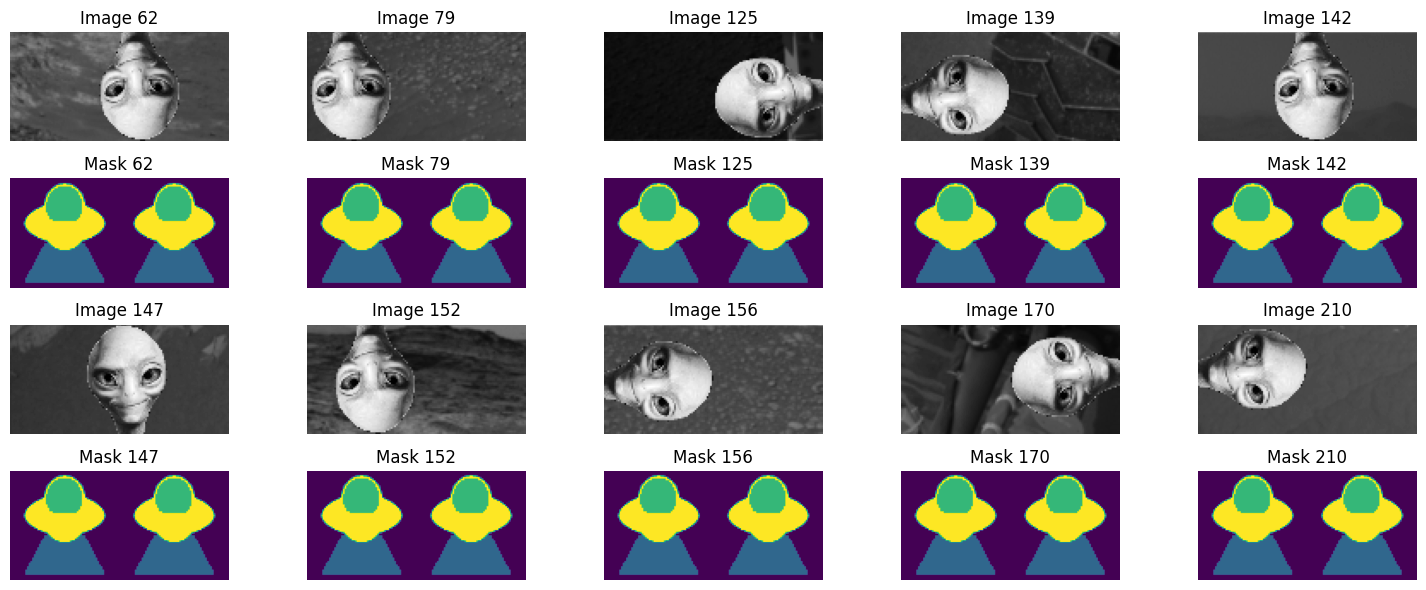

In [15]:
import numpy as np

# List to store the indices of alien masks
alien_mask_indices = []

# Iterate over the training set masks and compare each mask with the alien mask
for i, mask in enumerate(y_train_val):
    if np.array_equal(mask, alien_mask_example):
        alien_mask_indices.append(i)

# Print the number of alien instances found
print(f"Found {len(alien_mask_indices)} instances of the alien mask.")

# Visualize the alien images and their masks
visualize_alien_images(X_train_val, y_train_val, alien_mask_indices, num_images=10)


Removed 110 alien images from the training set.


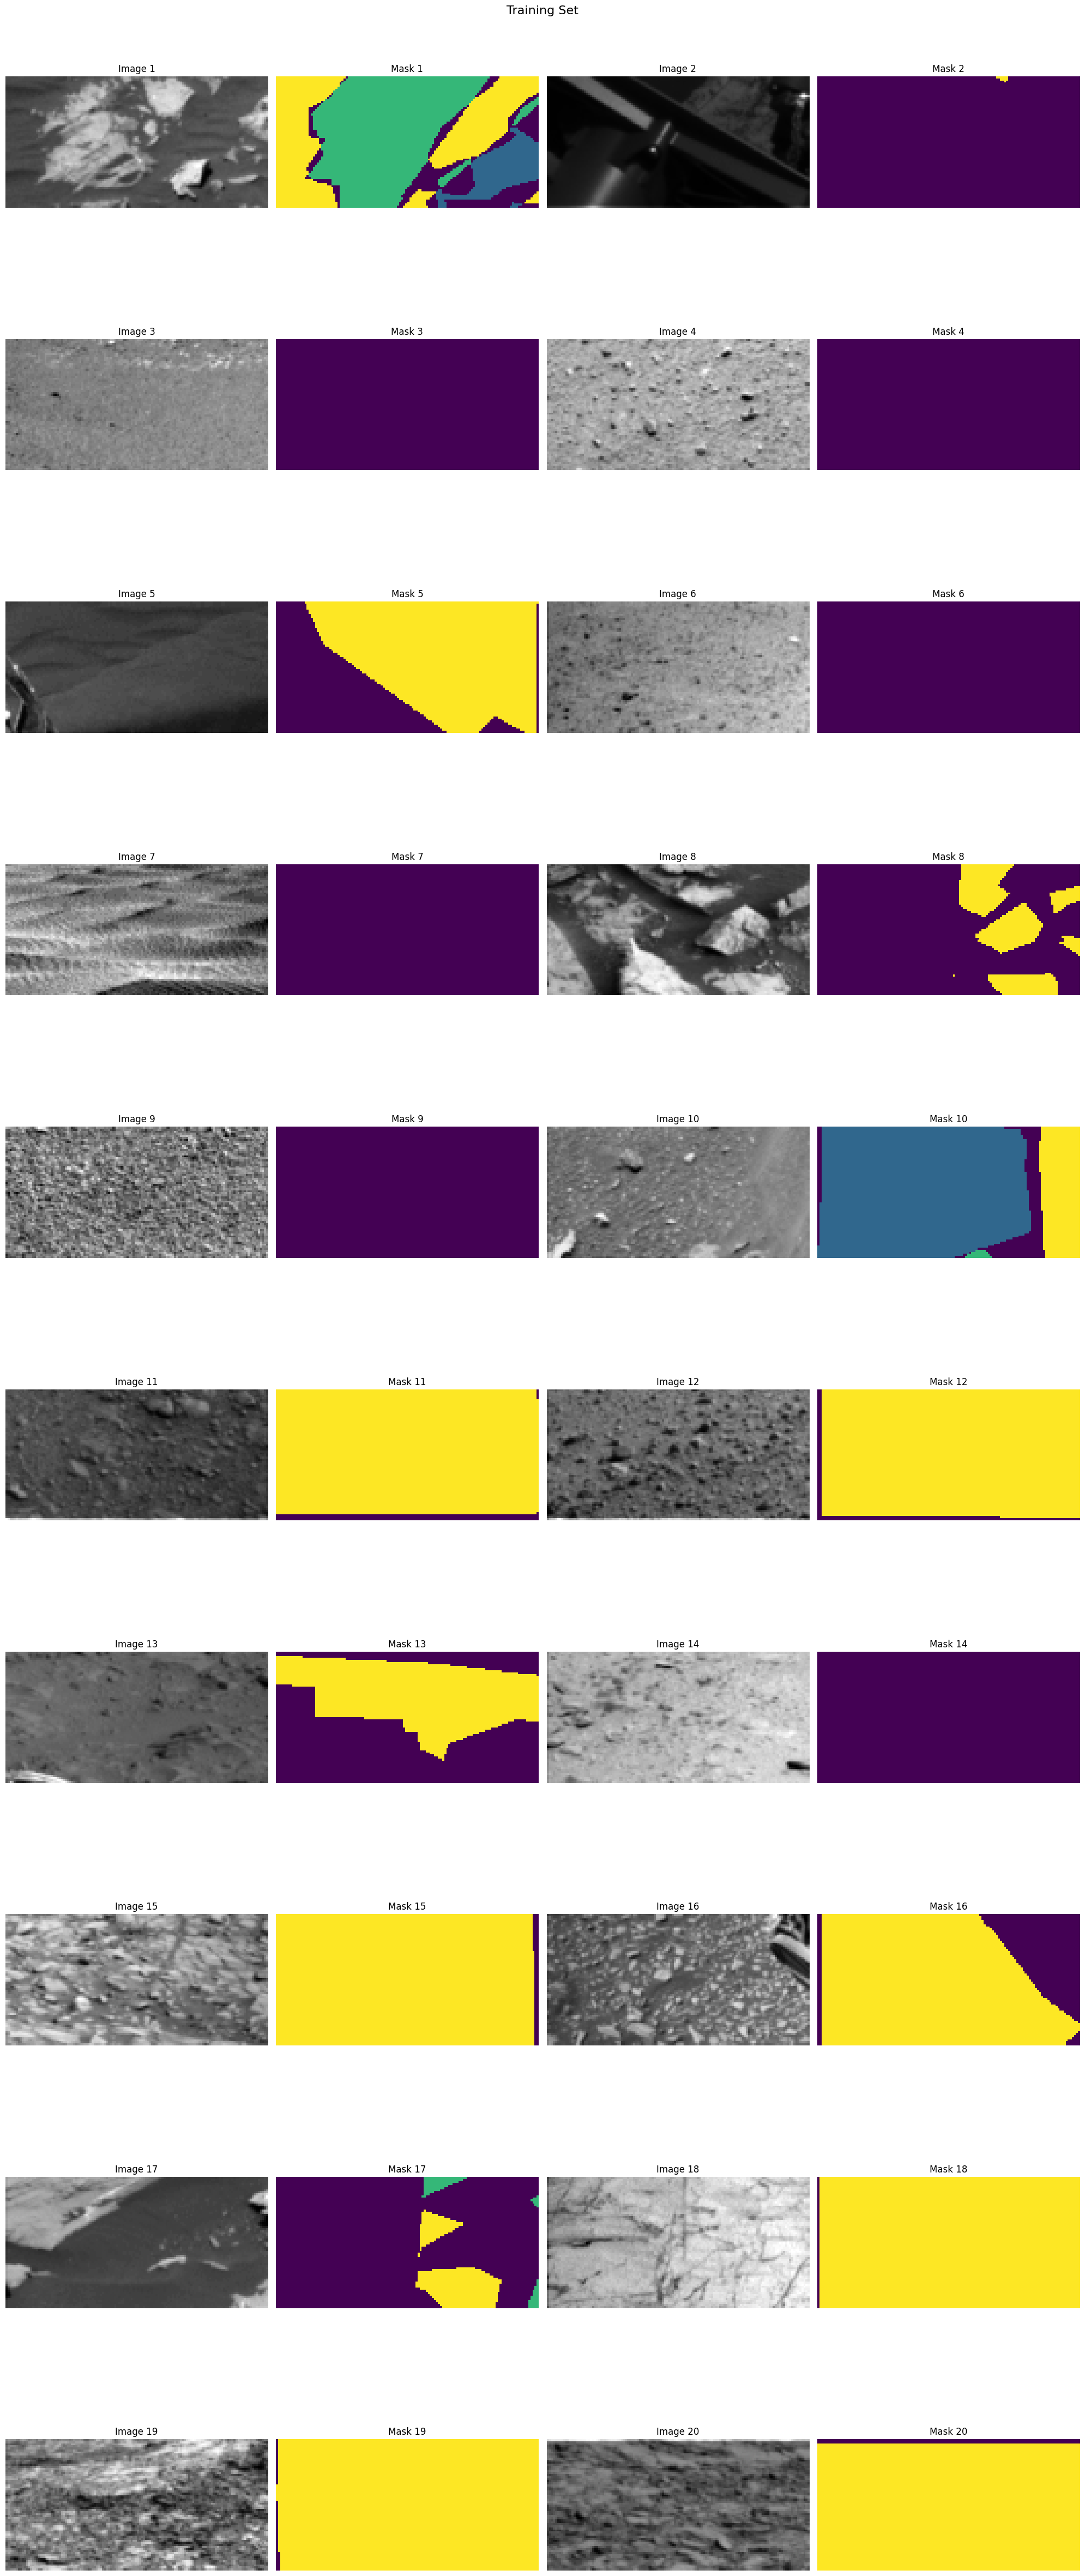

In [16]:
# Remove the alien images and their masks from the training set
X_train_val_filtered = np.delete(X_train_val, alien_mask_indices, axis=0)
y_train_val_filtered = np.delete(y_train_val, alien_mask_indices, axis=0)

print(f"Removed {len(alien_mask_indices)} alien images from the training set.")

# As we can see, the aliens images at indexes 62 and 79 we saw before have been removed
visualize_images_with_mask(X_train_val_filtered[60:80], masks=y_train_val_filtered[60:80], num_images=20, title="Training Set")

## Class distribution after alien removal

Class Occurrences in Training Set after Alien Removal:
Class 0 - Background: 4988826 pixels
Class 1 - Soil: 6957538 pixels
Class 2 - Bedrock: 4776810 pixels
Class 3 - Sand: 3770823 pixels
Class 4 - Big Rock: 26963 pixels


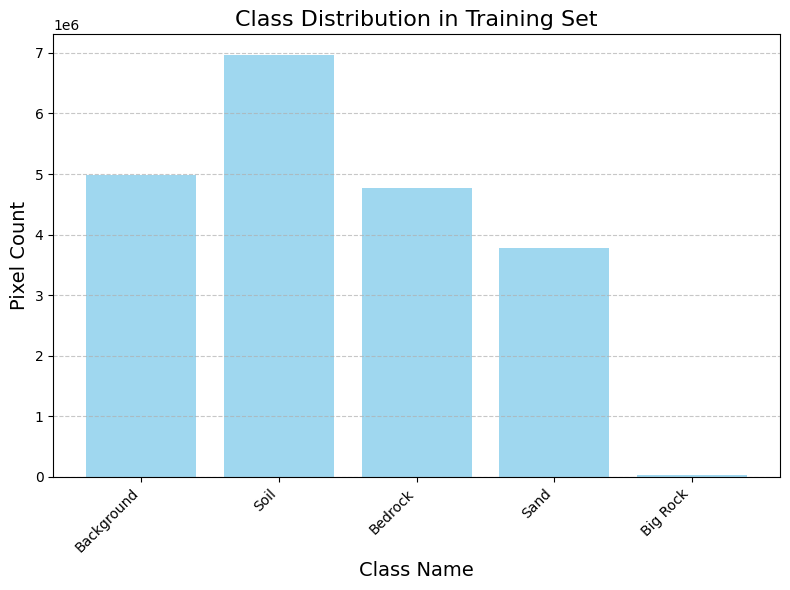

In [17]:
masks = np.array([y.squeeze() for y in y_train_val_filtered])

class_counts = count_class_occurrences(masks, num_classes=num_classes)

print("Class Occurrences in Training Set after Alien Removal:")
for class_id, count in class_counts.items():
    print(f"Class {class_id} - {class_names[class_id]}: {count} pixels")

plot_class_distribution(class_counts, class_names, title="Class Distribution in Training Set")

# 🛠️ Train and Save the Model

## Train and validation split

In [18]:
# Train and validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_val_filtered, y_train_val_filtered, test_size=0.2,random_state= 42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (2004, 64, 128), y_train shape: (2004, 64, 128)
X_val shape: (501, 64, 128), y_val shape: (501, 64, 128)
X_test shape: (10022, 64, 128)


In [19]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


## Class weights

In [20]:
# Flatten the masks to get pixel-wise class distribution
y_train_flat = np.argmax(y_train, axis=-1).flatten()

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flat),
    y=y_train_flat
)

# Create a dictionary mapping class index to weight
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)


Class weights: {0: 0.012528132033008251, 1: 0.12167577413479053, 2: 0.13322696449940166, 3: 0.2959243945658594, 4: 0.4236786469344609, 5: 0.8246913580246914, 6: 1.745644599303136, 7: 2.887608069164265, 8: 2.5175879396984926, 9: 2.982142857142857, 10: 2.982142857142857, 11: 2.9557522123893807, 12: 3.528169014084507, 13: 3.5531914893617023, 14: 3.443298969072165, 15: 3.0, 16: 3.4551724137931035, 17: 3.121495327102804, 18: 3.7388059701492535, 19: 3.2427184466019416, 20: 3.6043165467625897, 21: 3.7111111111111112, 22: 3.5406360424028267, 23: 3.8988326848249026, 24: 3.8098859315589353, 25: 3.9140625, 26: 4.3755458515283845, 27: 3.9761904761904763, 28: 4.008, 29: 3.656934306569343, 30: 3.5034965034965033, 31: 3.853846153846154, 32: 4.1234567901234565, 33: 4.318965517241379, 34: 4.282051282051282, 35: 4.513513513513513, 36: 4.263829787234043, 37: 4.53393665158371, 38: 4.433628318584071, 39: 4.575342465753424, 40: 4.3755458515283845, 41: 3.752808988764045, 42: 4.53393665158371, 43: 4.887804878

In [65]:
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
def weighted_sparse_categorical_crossentropy(weights):
    # Convert weights dictionary into a tensor
    weights = tf.constant(list(weights.values()), dtype=tf.float32)

    def loss(y_true, y_pred):
        # Ensure labels are integers
        y_true = tf.cast(y_true, tf.int32)
        
        # Compute sparse categorical cross-entropy loss
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        
        # Gather the corresponding weights for each class in y_true
        weights_map = tf.gather(weights, y_true)
        
        # Squeeze the weights_map to remove the extra dimension (from shape [?, ?, ?, 1] to [?, ?, ?])
        weights_map = tf.squeeze(weights_map, axis=-1)  # Remove the last dimension
        
        # Multiply each loss by its corresponding class weight
        weighted_loss = loss * weights_map
        
        return tf.reduce_mean(weighted_loss)

    return loss

loss_function = weighted_sparse_categorical_crossentropy(class_weight_dict)

## Making datasets

In [66]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent rando
    horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [67]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    dataset = dataset.map(lambda x, y: (x, y))
    
    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [68]:
y_train_expanded = tf.expand_dims(y_train, axis=-1)
y_val_expanded = tf.expand_dims(y_val, axis=-1)

train_dataset = make_dataset(
    X_train, y_train_expanded,
    batch_size=64,
    shuffle=True,
    augment=True,
    seed=42
)

val_dataset = make_dataset(
    X_val, y_val_expanded,
    batch_size=64,
    shuffle=False
)

for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break


Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float64'>


## Model definition

In [69]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [70]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=42):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [71]:
model = get_unet_model()

# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model.compile(optimizer="adam", loss=loss_function, metrics=["accuracy", mean_iou])

model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv1   │ (None, 64, 128,   │        320 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn1     │ (None, 64, 128,   │        128 │ down_block1_conv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn1[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv2   │ (None, 64, 128,   │      9,248 │ down_block1_acti… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn2     │ (None, 64, 128,   │        128 │ down_block1_conv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn2[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 64,    │          0 │ down_block1_acti… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv1   │ (None, 32, 64,    │     18,496 │ max_pooling2d_2[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn1     │ (None, 32, 64,    │        256 │ down_block2_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_activa… │ (None, 32, 64,    │          0 │ down_block2_bn1[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv2   │ (None, 32, 64,    │     36,928 │ down_block2_acti… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn2     │ (None, 32, 64,    │        256 │ down_block2_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_activa… │ (None, 32, 64,    │          0 │ down_block2_bn2[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 32,    │          0 │ down_block2_acti… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneckconv1     │ (None, 16, 32,    │     73,856 │ max_pooling2d_3[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneckbn1       │ (None, 16, 32,    │        512 │ bottleneckconv1[

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

## Callbacks

In [72]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='max',
    patience=30,
    restore_best_weights=True
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

## Train the model

In [73]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=300,
    validation_data=val_dataset,
    callbacks=[early_stopping, lr_reduce],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/300


I0000 00:00:1733476441.199890     135 service.cc:145] XLA service 0x7b7378001180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733476441.199972     135 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733476441.199979     135 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733476441.800351     135 assert_op.cc:38] Ignoring Assert operator compile_loss/loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-12-06 09:14:09.128376: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[64,96,64,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,64,128]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config

 1/32 ━━━━━━━━━━━━━━━━━━━━ 12:04 23s/step - accuracy: 0.1664 - loss: 0.2279 - mean_io_u_1: 0.0753

I0000 00:00:1733476458.660579     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3442 - loss: 0.1611 - mean_io_u_1: 0.1806

W0000 00:00:1733476462.661369     136 assert_op.cc:38] Ignoring Assert operator compile_loss/loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.3463 - loss: 0.1604 - mean_io_u_1: 0.1819

W0000 00:00:1733476472.066293     134 assert_op.cc:38] Ignoring Assert operator compile_loss/loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733476473.055069     136 assert_op.cc:38] Ignoring Assert operator compile_loss/loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 551ms/step - accuracy: 0.3482 - loss: 0.1596 - mean_io_u_1: 0.1831 - val_accuracy: 0.2076 - val_loss: 14.4102 - val_mean_io_u_1: 0.0689 - learning_rate: 0.0010
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.4815 - loss: 0.1100 - mean_io_u_1: 0.2876 - val_accuracy: 0.2077 - val_loss: 35.6452 - val_mean_io_u_1: 0.0689 - learning_rate: 0.0010
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.5188 - loss: 0.0970 - mean_io_u_1: 0.3269 - val_accuracy: 0.2064 - val_loss: 29.1259 - val_mean_io_u_1: 0.0563 - learning_rate: 0.0010
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.5422 - loss: 0.0891 - mean_io_u_1: 0.3433 - val_accuracy: 0.2359 - val_loss: 9.3044 - val_mean_io_u_1: 0.0095 - learning_rate: 0.0010
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.5519 - loss: 0.0860 - mean_io_u_1: 0.3532 - val_accuracy: 0.2289 - val_loss: 11.6801 - val_mean_io_u_1: 0.0554 - learning_rate: 0.0010
Ep

In [74]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241206_092253.keras


## Plot validation and loss

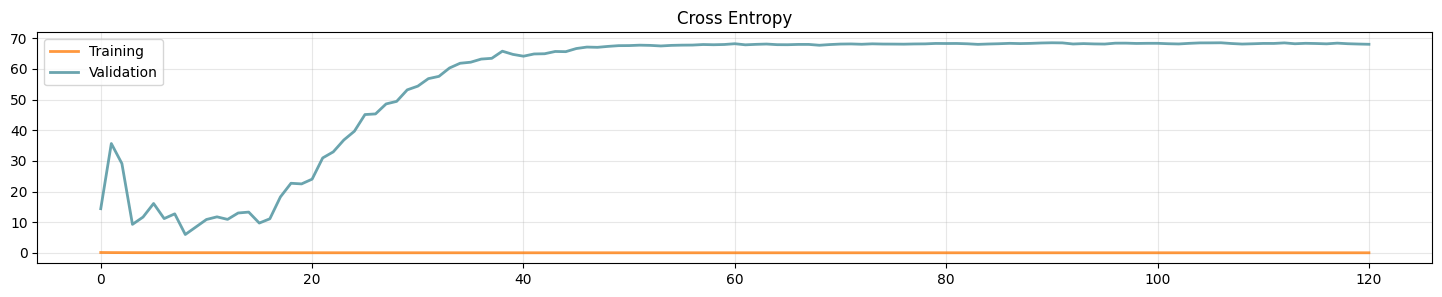

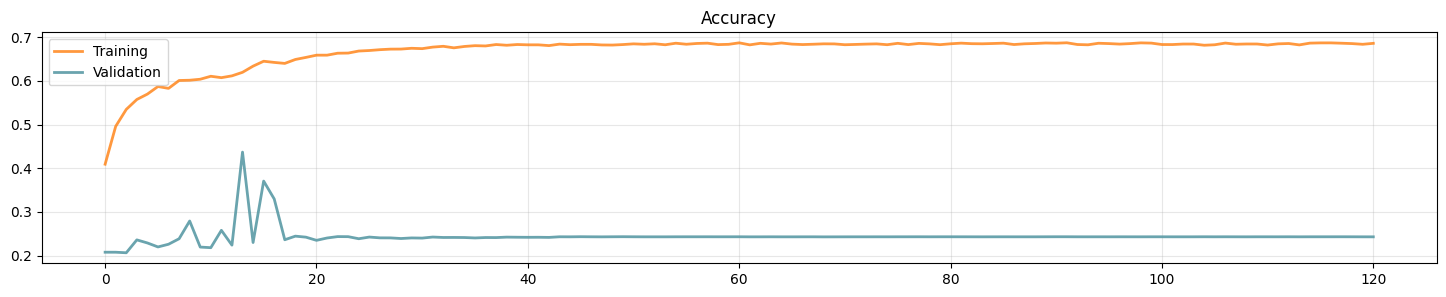

In [75]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
# plt.figure(figsize=(18, 3))
# plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
# plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
# plt.title('Mean Intersection over Union')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()

# 📊 Prepare Your Submission



In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.






In [76]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [77]:
from tensorflow.keras.models import load_model
print(f"Model filename: {model_filename}")
model = load_model(model_filename, custom_objects={'loss': weighted_sparse_categorical_crossentropy})
print(f"Model loaded from {model_filename}")

Model filename: model_241206_092253.keras
Model loaded from model_241206_092253.keras


In [78]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
Predictions shape: (10022, 64, 128)


In [79]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [80]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)